## PaySim Fraud Detection Case using XGBoost
### This notebook demonstrates the process of detecting fraudulent transactions using the XGBoost classifier. It includes data preprocessing, exploratory data analysis, feature engineering, model training, evaluation, and preparation for deployment.

In [2]:
# 0. Installing necessary packages
!pip uninstall -y scikit-learn
!pip install -q scikit-learn==1.3.1
!pip install -q xgboost
!pip install -q graphviz

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.8 MB/s eta 0:00:00


In [47]:
# 1. Importing necessary libraries and suppressing warnings for cleaner output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,precision_score, recall_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from xgboost import XGBClassifier,plot_importance,plot_tree
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)
pd.set_option('chained_assignment',None)
xgb.set_config(use_rmm=True)

In [48]:
# 2. Importing the data
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Portfolio Projects/PaySim_Fraud_Detection_XGBoost/data/raw

raw_data = pd.read_csv('train.csv')
data=raw_data.copy()

# 2.b Changing the directory to export plots
%cd /content/drive/My Drive/Portfolio Projects/PaySim_Fraud_Detection_XGBoost/images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Portfolio Projects/PaySim_Fraud_Detection_XGBoost/data/raw
/content/drive/My Drive/Portfolio Projects/PaySim_Fraud_Detection_XGBoost/images


In [49]:
# 3. Checking for the first few rows and null values
display(data.head())
print(data.isnull().sum())

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,0,0,TRANSFER,10.00,C0198526315,30112.00,30102.00,C4653045645,21927.84,21937.84,0,0
1,1,1,CASH_IN,104925.19,C9864462944,42.23,104967.41,C7853342674,0.00,0.00,0,0
2,2,1,CASH_IN,37383.17,C1474610910,49.83,37433.01,C3584357969,0.00,0.00,0,0
3,3,1,CASH_IN,131908.49,C1474610910,37433.01,169341.49,C4996589500,0.00,0.00,0,0
4,4,1,CASH_IN,127105.65,C1474610910,169341.49,296447.14,C5989915138,0.00,0.00,0,0


Id                0
step              0
action            0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [50]:
# 4. Displaying descriptive statistics of the dataset
display(data.describe())

,Id,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,2.372805e+06,2.372805e+06,2.372805e+06,2.372805e+06,2.372805e+06,2.372805e+06,2.372805e+06,2.372805e+06,2372805.0
mean,1.676995e+06,1.832920e+02,1.454519e+05,3.332226e+06,3.315864e+06,2.823591e+05,3.299378e+05,7.501670e-05,0.0
std,9.679376e+05,1.258774e+02,3.122165e+05,1.777183e+06,1.744702e+06,9.554569e+05,1.138435e+06,8.660895e-03,0.0
min,0.000000e+00,0.000000e+00,1.100000e-01,-1.959696e+05,-1.959696e+05,-1.439078e+05,-6.233257e+04,0.000000e+00,0.0
25%,8.383540e+05,4.400000e+01,1.436889e+04,2.563357e+06,2.559986e+06,2.179805e+04,2.391135e+04,0.000000e+00,0.0
50%,1.677475e+06,1.870000e+02,9.785308e+04,3.425072e+06,3.407159e+06,7.714657e+04,7.965216e+04,0.000000e+00,0.0
75%,2.515399e+06,2.650000e+02,1.714096e+05,4.117519e+06,4.089955e+06,1.414099e+05,1.443928e+05,0.000000e+00,0.0
max,3.352886e+06,7.180000e+02,2.026857e+07,4.955674e+07,4.882798e+07,4.783798e+07,4.799305e+07,1.000000e+00,0.0


In [51]:
# 5. Data Cleaning and Feature Engineering

# Dropping the 'isFlaggedFraud' column as it contains only 0s
data.drop(columns=['isFlaggedFraud'], inplace=True,errors='ignore')

# Creating temporal features based on the 'step' column
data['hour_of_day'] = data['step'] % 24
data['day_of_week'] = (data['step'] // 24) % 7
data['day']=(data['step'] // 24)

# Checking the distribution of fraudulent transactions
print(data['isFraud'].value_counts())
fraud_rate = data['isFraud'].mean()
print(data['isFraud'].value_counts(normalize=True))

isFraud
0    2372627
1        178
Name: count, dtype: int64
isFraud
0    0.999925
1    0.000075
Name: proportion, dtype: float64


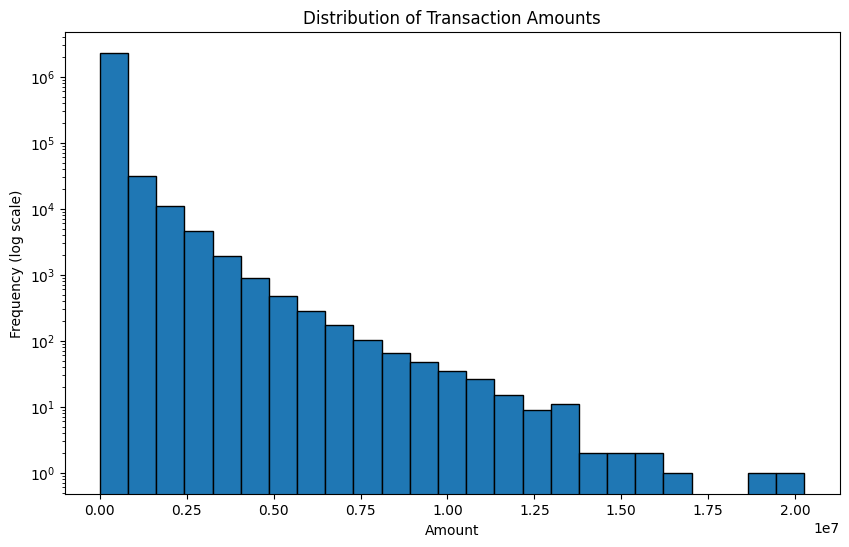

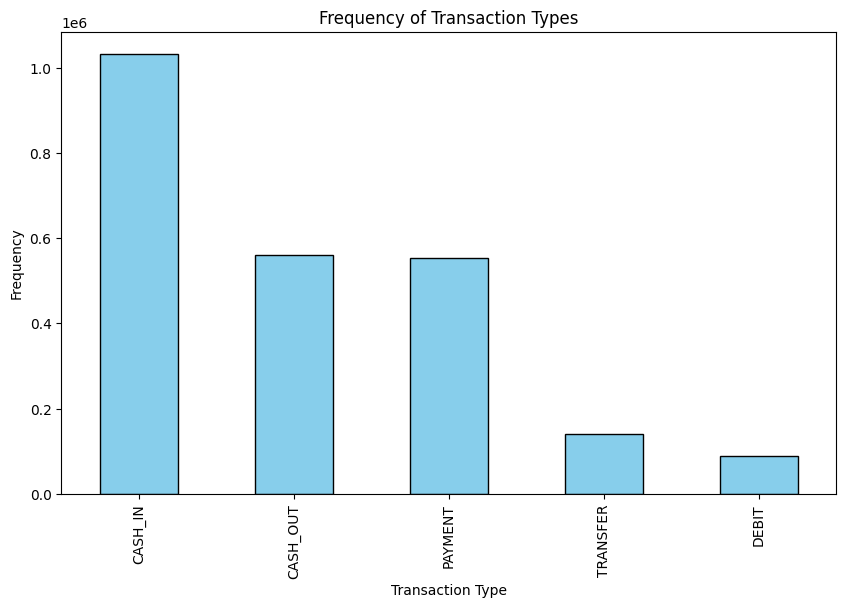

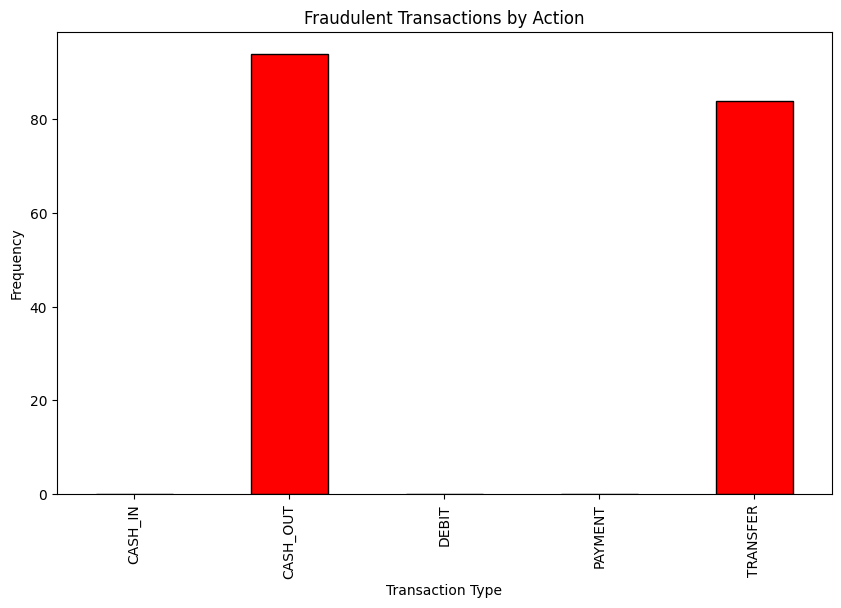

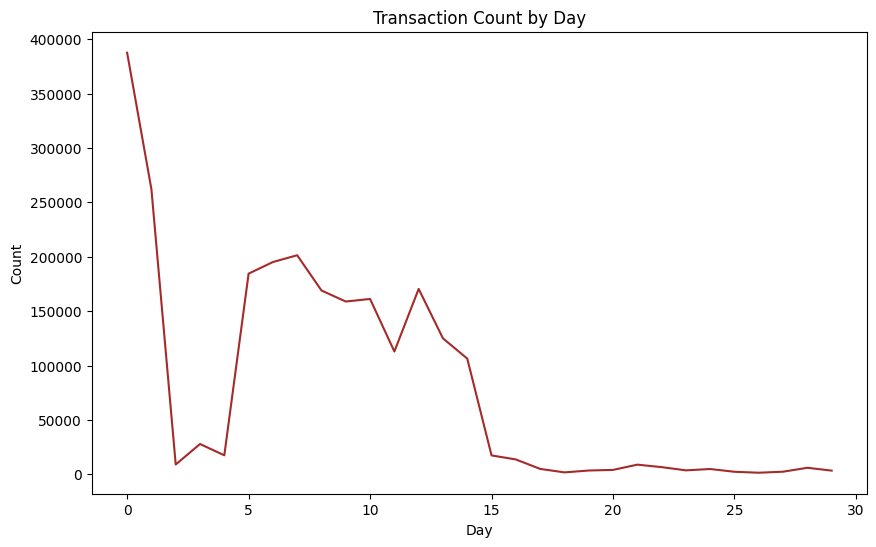

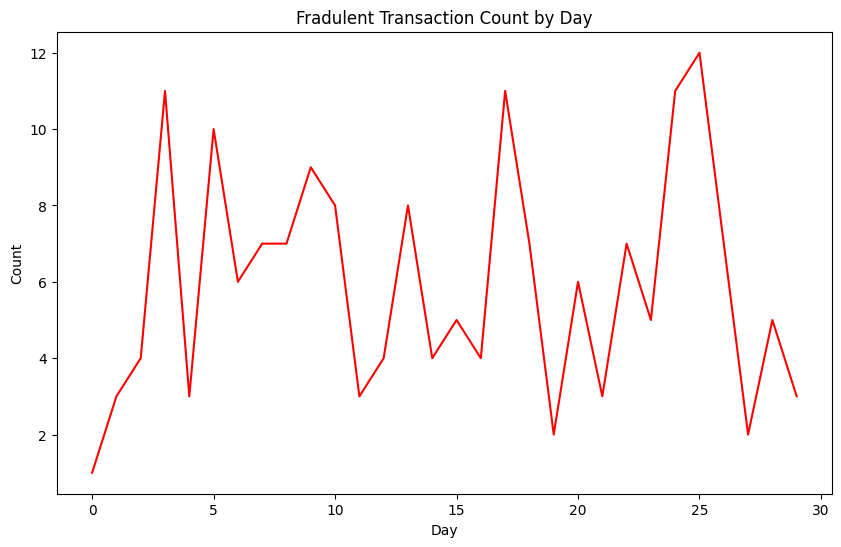

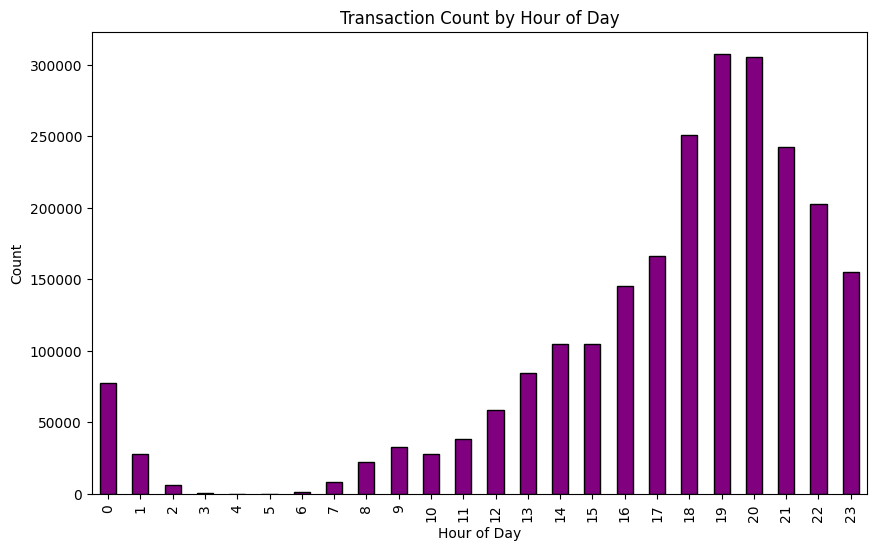

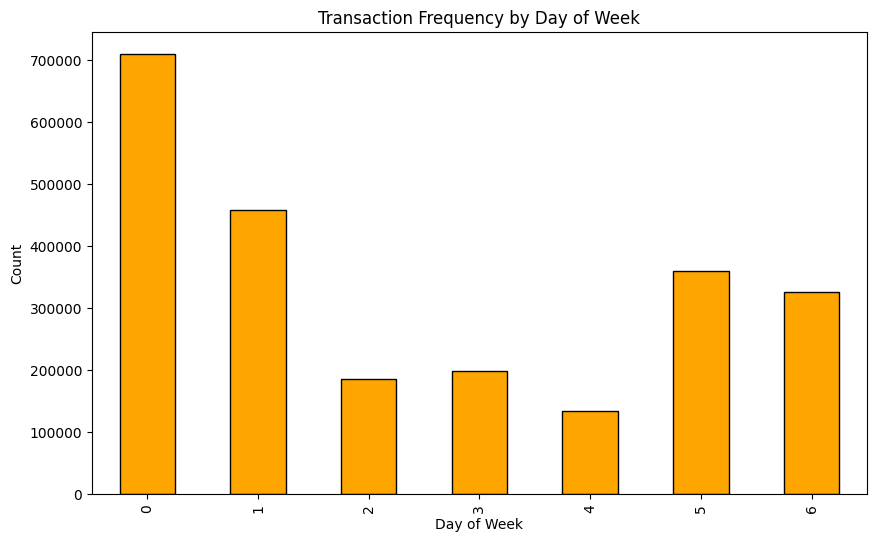

In [52]:
# 6. Exploratory Data Analysis (EDA)

# 1. Distribution of transaction amounts
plt.figure(figsize=(10, 6))
plt.hist(data.amount, bins=25, log=True, edgecolor='k')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency (log scale)')
plt.savefig('distribution_transaction_amounts.png')  # Save the figure
plt.show()

# 2. Frequency of transaction types
plt.figure(figsize=(10, 6))
data['action'].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Frequency of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.savefig('frequency_transaction_types.png')  # Save the figure
plt.show()

# 3. Fraudulent Transactions by Action Type
plt.figure(figsize=(10, 6))
data.groupby('action')['isFraud'].sum().plot(kind='bar', color='red', edgecolor='k')
plt.title('Fraudulent Transactions by Action')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.savefig('fraudulent_transactions_by_action.png')  # Save the figure
plt.show()

# 4. Transaction Count by Day
plt.figure(figsize=(10, 6))
data.groupby('day').size().plot(kind='line', color='brown',)
plt.title('Transaction Count by Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.savefig('transaction_count_by_day.png')  # Save the figure
plt.show()

# 5. Fraudulent Transaction Count by Day
plt.figure(figsize=(10, 6))
data[data.isFraud==1].groupby('day').size().plot(kind='line', color='red')
plt.title('Fradulent Transaction Count by Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.savefig('fraudulent_transaction_count_by_day.png')  # Save the figure
plt.show()

# 6. Transaction Count by Hour of Day
plt.figure(figsize=(10, 6))
data.groupby('hour_of_day').size().plot(kind='bar', color='purple', edgecolor='k')
plt.title('Transaction Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.savefig('transaction_count_by_hour_of_day.png')  # Save the figure
plt.show()

# 7. Transaction Frequency by Day of Week
plt.figure(figsize=(10, 6))
data.groupby('day_of_week').size().plot(kind='bar', color='orange', edgecolor='k')
plt.title('Transaction Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.savefig('transaction_frequency_by_day_of_week.png')  # Save the figure
plt.show()

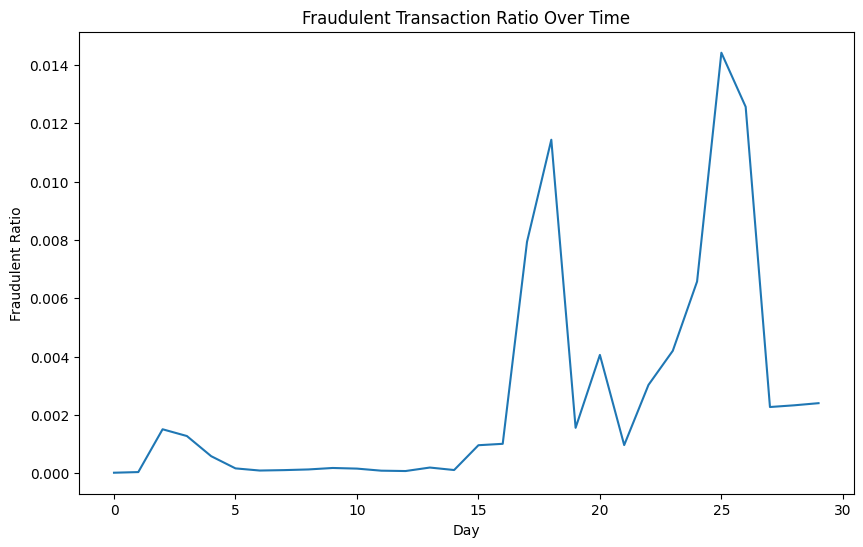

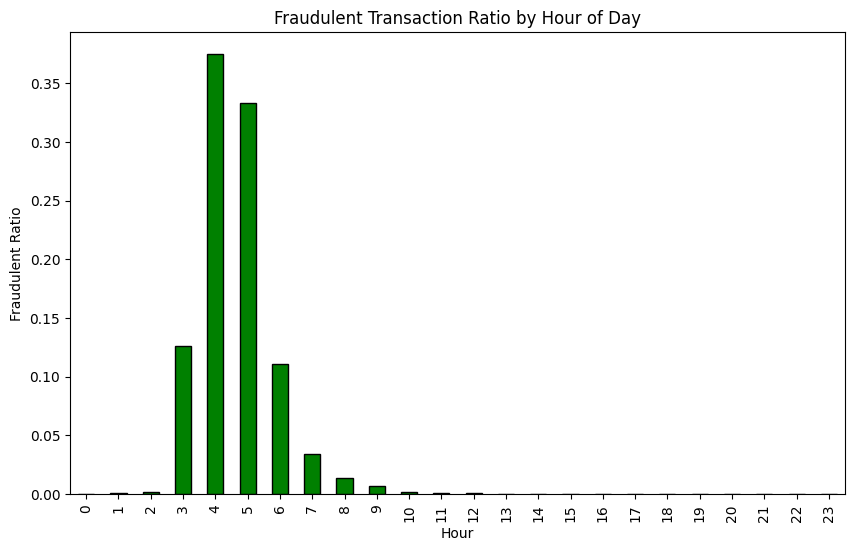

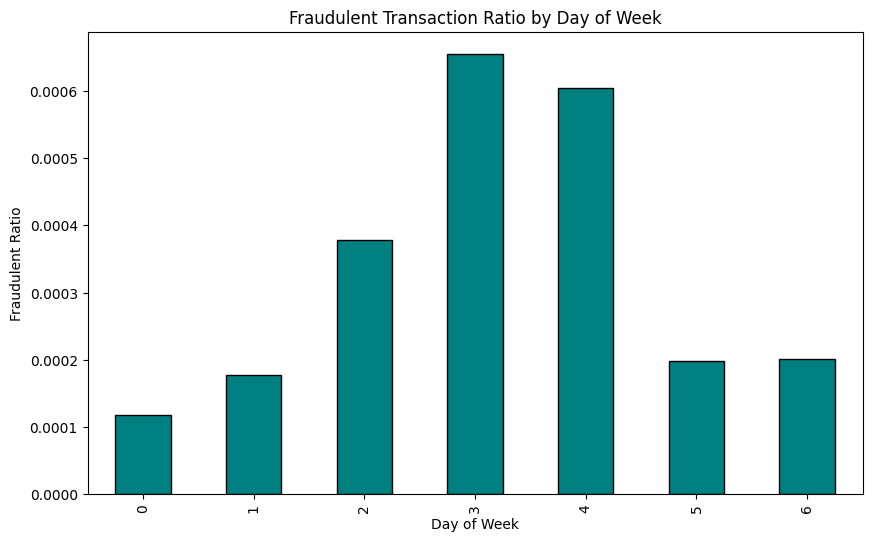

In [53]:
# 7. Filtering Transaction Types for Fraud Analysis

# Since fraudulent transactions consist of only 'CASH_OUT' and 'TRANSFER' actions,
# we filter these transaction types for meaningful comparison between fraudulent and non-fraudulent transactions.
data_action_filtered = data[data.action.isin(["CASH_OUT", "TRANSFER"])]

# 1. Fraudulent Transaction Ratio Over Time
plt.figure(figsize=(10, 6))
plt.plot(data_action_filtered.groupby('day')['isFraud'].mean())
plt.xlabel('Day')
plt.ylabel('Fraudulent Ratio')
plt.title('Fraudulent Transaction Ratio Over Time')
plt.savefig('fradulent_transaction_ratio_over_time.png')  # Save the figure
plt.show()

# 2. Fraudulent Transaction Ratio by Hour
plt.figure(figsize=(10, 6))
data_action_filtered.groupby('hour_of_day')['isFraud'].mean().plot(kind="bar", edgecolor='k', color='green')
plt.xlabel('Hour')
plt.ylabel('Fraudulent Ratio')
plt.title('Fraudulent Transaction Ratio by Hour of Day')
plt.savefig('fradulent_transaction_ratio_by_hour_of_day.png')  # Save the figure
plt.show()

# 3. Fraudulent Transaction Ratio by Day of Week
plt.figure(figsize=(10, 6))
data_action_filtered.groupby('day_of_week')['isFraud'].mean().plot(kind="bar", edgecolor='k', color='teal')
plt.xlabel('Day of Week')
plt.ylabel('Fraudulent Ratio')
plt.title('Fraudulent Transaction Ratio by Day of Week')
plt.savefig('fradulent_transaction_ratio_by_day_of_week.png')  # Save the figure
plt.show()

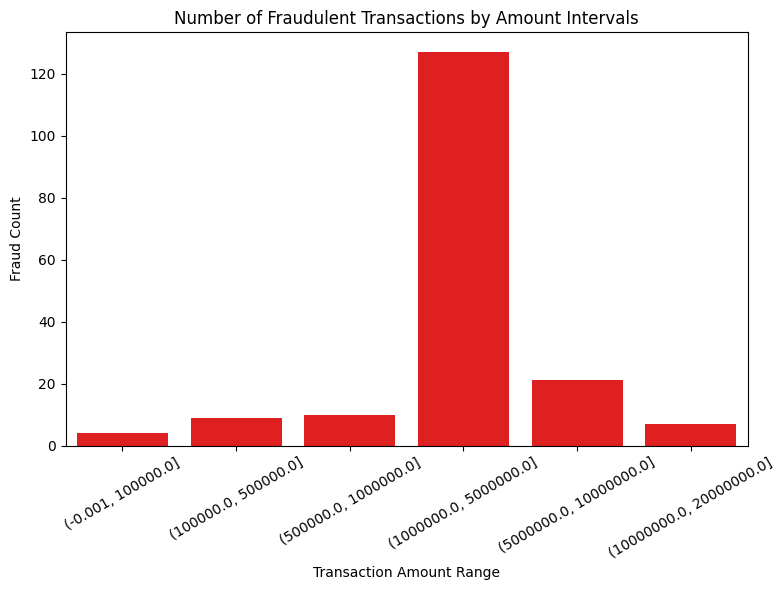

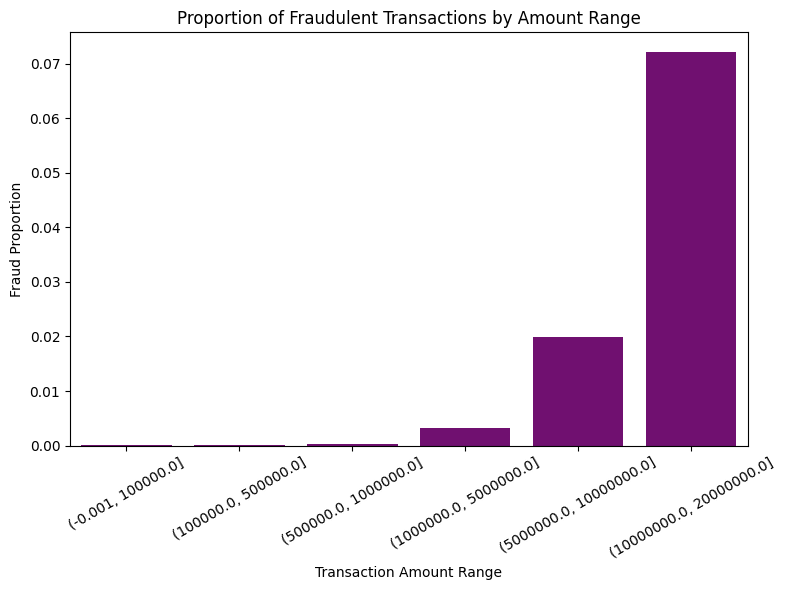

In [54]:
# 8. Binning Transaction Amounts and Analyzing Fraud

# Define bin edges for transaction amounts
bin_edges = [0, 1e5, 5e5, 1e6, 5e6, 1e7, 2e7]
data_action_filtered['amount_bin'] = pd.cut(data_action_filtered['amount'], bins=bin_edges, include_lowest=True)

# Calculate fraud counts and proportions per bin
fraud_counts = data_action_filtered.groupby('amount_bin')['isFraud'].sum().reset_index()
fraud_proportions = data_action_filtered.groupby('amount_bin')['isFraud'].mean().reset_index()

# Visualizing fraud count by transaction amount bins
plt.figure(figsize=(8, 6))
sns.barplot(x='amount_bin', y='isFraud', data=fraud_counts, color='red')
plt.title('Number of Fraudulent Transactions by Amount Intervals')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Fraud Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('number_of_fraudulent_transactions_by_amount_intervals.png')  # Save the figure
plt.show()

# Visualizing fraud proportion by transaction amount bins
plt.figure(figsize=(8, 6))
sns.barplot(x='amount_bin', y='isFraud', data=fraud_proportions, color='purple')
plt.title('Proportion of Fraudulent Transactions by Amount Range')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Fraud Proportion')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('proportion_of_fraudulent_transactions_by_amount_range.png')  # Save the figure

plt.show()

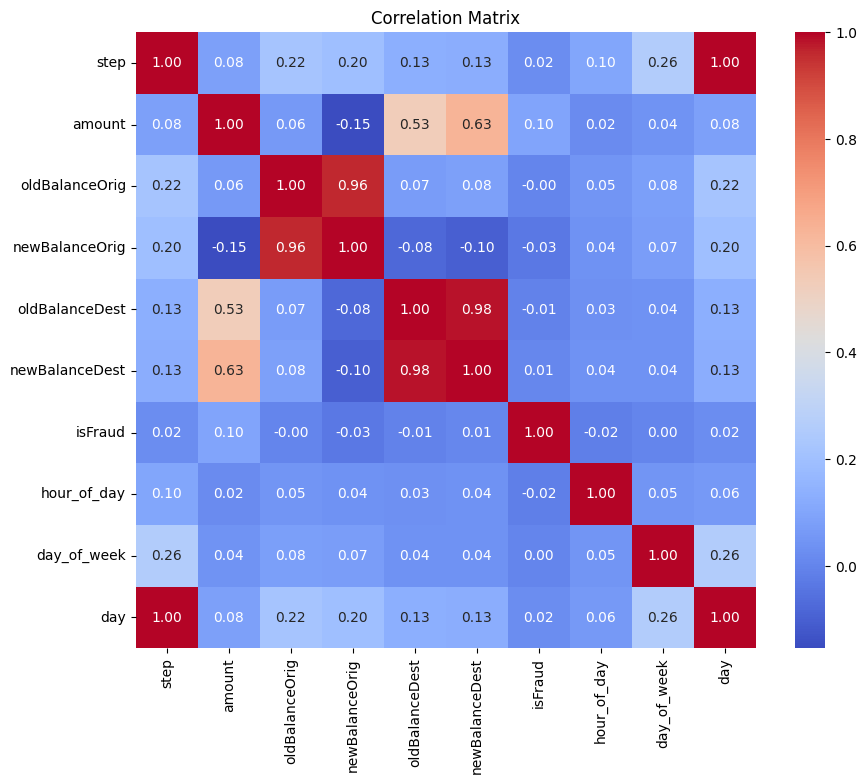

In [55]:
# 9. Correlation Analysis

# Selecting numeric and boolean columns for correlation
numeric_cols = data_action_filtered.drop(['Id'], axis=1).select_dtypes(include=['number', 'bool']).columns
correlation_matrix = data_action_filtered[numeric_cols].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')  # Save the figure
plt.show()

In [56]:
# 10. Encoding Categorical Features

# Extracting the first character from 'nameDest' to create a new categorical feature
data['nameDest_type'] = data['nameDest'].str[0].map({'C': 'customer', 'B': 'merchant'}).fillna('other')

# One-hot encoding categorical variables
data = pd.get_dummies(data, columns=['nameDest_type'], dtype="int64")  # Encode 'nameDest_type'
data = pd.get_dummies(data, columns=['action'], dtype="int64")  # Encode 'action'

In [57]:
# 11. Splitting Features and Target Variable

# Defining feature matrix X and target vector y
X = data.drop(['isFraud', 'Id', 'nameOrig', 'nameDest', 'amount_bin'], axis=1, errors='ignore')
y = data['isFraud'].values

# Splitting the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

# Calculating scale_pos_weight to handle class imbalance
fraud_ratio_train = y_train.mean()
scale_pos_weight = (1 - fraud_ratio_train) / fraud_ratio_train

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best parameters found: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 6, 'method': 'hist', 'n_estimators': 100, 'subsample': 0.8}
Best AUC score during CV: 0.9984066478323751
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    593157
           1       0.53      0.96      0.68        45

    accuracy                           1.00    593202
   macro avg       0.77      0.98      0.84    593202
weighted avg       1.00      1.00      1.00    593202

ROC AUC: 0.9998861459388773


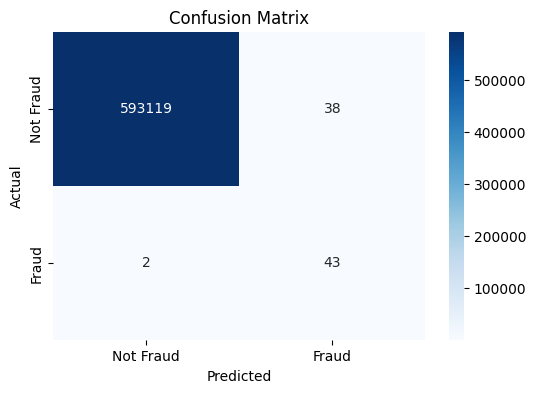

In [58]:
# 12. Initial Model Training with XGBoost and Hyperparameter Tuning

# Defining the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1,0.3],
    'subsample': [0.8, 1.0],
    'device':['cuda'],
    'method':['hist'],
}

# Initializing the XGBoost classifier with specified objective and scale_pos_weight
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr',
)

# Setting up GridSearchCV for hyperparameter tuning with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fitting Grid Search on the training data
grid_search.fit(X_train, y_train)

# Displaying the best parameters and corresponding AUC score
print("Best parameters found:", grid_search.best_params_)
print("Best AUC score during CV:", grid_search.best_score_)

# Extracting the best model from Grid Search
best_model = grid_search.best_estimator_

# Making predictions on the validation set
y_pred_best = best_model.predict(X_val)
y_pred_best_proba = best_model.predict_proba(X_val)[:, 1]

# Classification metrics on the validation set
print("Classification Report:")
print(classification_report(y_val, y_pred_best))
print("ROC AUC:", roc_auc_score(y_val, y_pred_best_proba))

# Confusion matrix for validation set
cm = confusion_matrix(y_val, y_pred_best)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('base_confusion_matrix.png')  # Save the figure
plt.show()

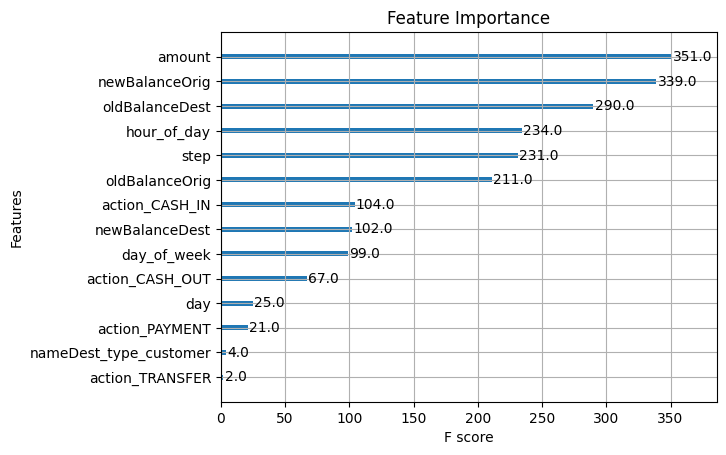

53281

In [59]:
# 13. Feature Importance Analysis

# Extracting feature importances from the best model
feature_importances = best_model.feature_importances_

# Getting feature names from the training set
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Creating a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plot_importance(best_model)
plt.title('Feature Importance')
plt.savefig('base_feature_importance.png')  # Save the figure
plt.show()

gc.collect()  # Garbage collection to free memory

In [60]:
# 14. Advanced Feature Engineering to Enhance Model Performance

# Sorting data to ensure proper cumulative calculations
data = data.sort_values(['step', 'nameOrig', 'Id'])

# Creating ratio features based on transaction amounts and balances
data['amountRatioOrig'] = data['amount'] / data['oldBalanceOrig']
data['amountRatioDest'] = data['amount'] / data['newBalanceOrig']  # Assuming 'newBalanceDest' was intended

# Cumulative transaction features for originating users
data['user_cum_count'] = data.groupby('nameOrig').cumcount()
data['user_cumulative_amount'] = data.groupby('nameOrig')['amount'].cumsum().shift(1)
data['user_avg_amount'] = data['user_cumulative_amount'] / data['user_cum_count']
data['user_max_amount'] = data.groupby('nameOrig')['amount'].cummax().shift(1)
data['user_avg_amount_ratio'] = data['amount'] / data['user_avg_amount']
data['user_max_amount_ratio'] = data['amount'] / data['user_max_amount']
data['prev_step'] = data.groupby('nameOrig')['step'].shift(1)
data['time_since_last'] = data['step'] - data['prev_step']
data['is_first_transaction'] = (data['prev_step'].isnull()).astype(int)

# Sorting again for same-step calculations
data = data.sort_values(by=['step', 'nameOrig', 'amount', 'nameDest'])

# Same-step and same-day transaction counts and amounts for users
data['user_count_same_step'] = data.groupby(['nameOrig', 'step']).cumcount() + 1
data['user_amount_same_step'] = data.groupby(['nameOrig', 'step'])['amount'].cumsum().shift(1)
data['user_count_same_day'] = data.groupby(['nameOrig', 'day']).cumcount() + 1
data['user_amount_same_day'] = data.groupby(['nameOrig', 'day'])['amount'].cumsum().shift(1)

# Sorting for destination-based feature engineering
data = data.sort_values(by=['step', 'nameDest', 'Id'])

# Same-day and same-step transaction counts and amounts for destination accounts
data['dest_count_same_day'] = data.groupby(['nameDest', 'day']).cumcount() + 1
data['dest_count_same_step'] = data.groupby(['nameDest', 'step']).cumcount() + 1
data['dest_amount_same_step'] = data.groupby(['nameDest', 'step'])['amount'].cumsum().shift(1)
data['dest_amount_same_day'] = data.groupby(['nameDest', 'day'])['amount'].cumsum().shift(1)

# Dropping 'amount_bin' as it's no longer needed
data.drop(['amount_bin'], axis=1, inplace=True, errors='ignore')

# Handling missing and infinite values
data.fillna(-1, inplace=True)
data.replace([np.inf, -np.inf], -1, inplace=True)

In [61]:
# 15. Preparing Data After Feature Engineering

# Defining feature matrix X and target vector y after feature engineering
X = data.drop(['isFraud', 'Id', 'nameOrig', 'nameDest', 'amount_bin', 'prev_step'], axis=1, errors='ignore')
y = data['isFraud'].values

# Splitting the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

# Recalculating scale_pos_weight to handle class imbalance in the new training set
fraud_ratio_train = y_train.mean()
scale_pos_weight = (1 - fraud_ratio_train) / fraud_ratio_train

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best parameters found: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 5, 'method': 'hist', 'n_estimators': 200, 'subsample': 0.8}
Best AUC score during CV: 0.9997971809881917
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    593157
           1       0.94      1.00      0.97        45

    accuracy                           1.00    593202
   macro avg       0.97      1.00      0.98    593202
weighted avg       1.00      1.00      1.00    593202

ROC AUC: 0.9999998126784121


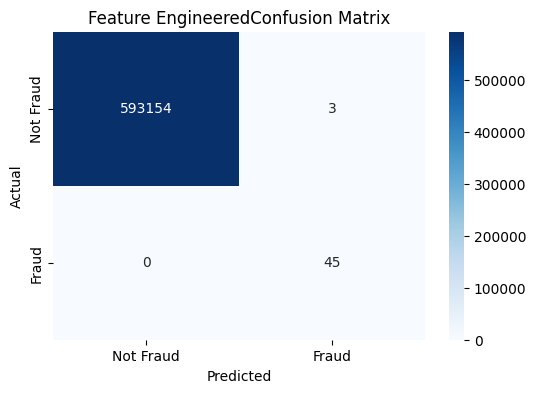

In [62]:
# 16. Model Training After Feature Engineering with Hyperparameter Tuning Using Stratified K-Fold Cross-Validation

# Defining Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

# Defining a new parameter grid for further tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1,0.3],
    'subsample': [0.8, 1.0],
    'device':['cuda'],
    'method':['hist'],
}

# Initializing the XGBoost classifier with updated parameters
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr'
)

# Setting up GridSearchCV with the new parameter grid and cross-validation strategy
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    n_jobs=-1
)

# Fitting Grid Search on the training data
grid_search.fit(X_train, y_train)

# Displaying the best parameters and corresponding AUC score from Grid Search
print("Best parameters found:", grid_search.best_params_)
print("Best AUC score during CV:", grid_search.best_score_)

# Extracting the best model from Grid Search
best_model = grid_search.best_estimator_

# Making predictions on the validation set
y_pred_best = best_model.predict(X_val)
y_pred_best_proba = best_model.predict_proba(X_val)[:, 1]

# Classification metrics on the validation set
print("Classification Report:")
print(classification_report(y_val, y_pred_best))
print("ROC AUC:", roc_auc_score(y_val, y_pred_best_proba))

# Confusion matrix for validation set
cm = confusion_matrix(y_val, y_pred_best)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Feature EngineeredConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('feature_engineered_confusion_matrix.png')  # Save the figure
plt.show()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2372627
           1       0.90      0.93      0.91       178

    accuracy                           1.00   2372805
   macro avg       0.95      0.96      0.96   2372805
weighted avg       1.00      1.00      1.00   2372805



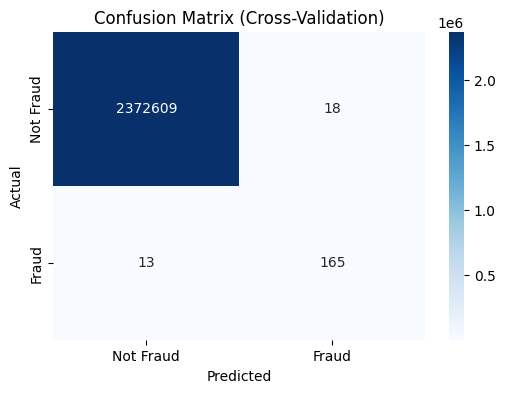

In [63]:
# 17. Cross-Validation Predictions on the Entire Dataset

# Defining Stratified K-Fold cross-validation with n splits
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

# Generating cross-validated predictions
y_pred_cv = cross_val_predict(best_model, X, y, cv=cv, method='predict')

# Classification report on the entire dataset using cross-validation predictions
print("Classification Report on Validation Set:")
print(classification_report(y, y_pred_cv))

# Confusion matrix for cross-validation results
cm = confusion_matrix(y, y_pred_cv)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix (Cross-Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cross_validation_confusion_matrix.png')  # Save the figure
plt.show()

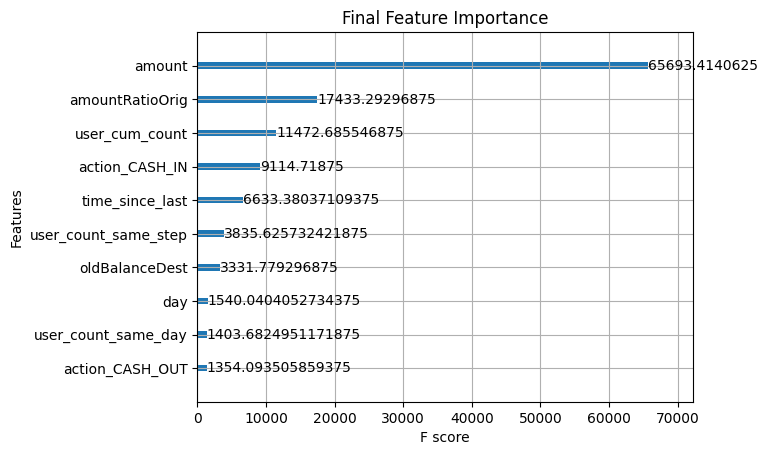

14393

In [64]:
# 18. Final Feature Importance and Tree Visualization

# Extracting final feature importances from the best model
feature_importances_final = best_model.feature_importances_

# Getting feature names from the training set
feature_names_final = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Creating a DataFrame for final feature importances
importance_df_final = pd.DataFrame({
    'Feature': feature_names_final,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

# Plotting the top 10 features based on gain importance
plot_importance(best_model, max_num_features=10, importance_type="gain")
plt.title('Final Feature Importance')
plt.savefig('final_feature_importance.png')  # Save the figure
plt.show()

gc.collect()  # Garbage collection to free memory

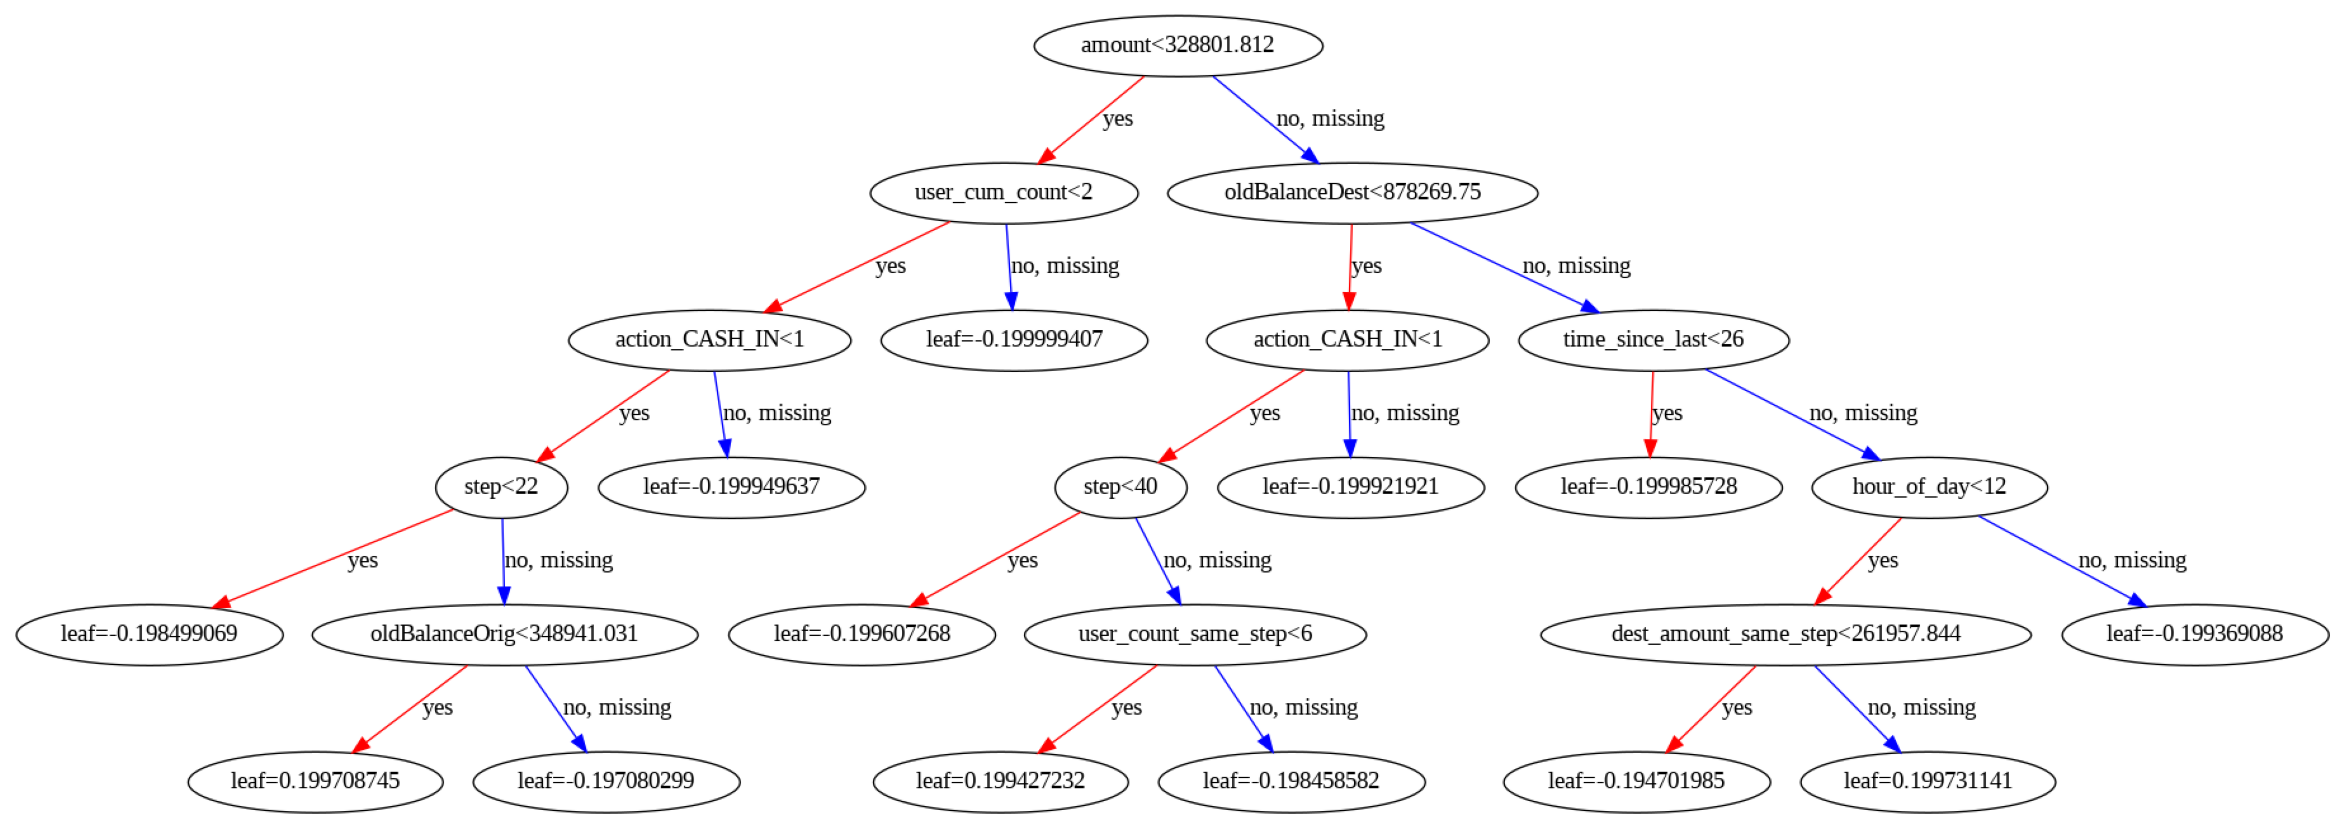

In [65]:
# 19. Visualizing the Decision Tree Structure

# Creating a large figure for the decision tree visualization
fig, ax = plt.subplots(figsize=(30, 30))

# Plotting the first tree in the XGBoost model
plot_tree(best_model, num_trees=0, ax=ax)
plt.savefig('decision_tree_structure.png')  # Save the figure
plt.show()

## Building Model Training and Evaluation Pipeline

In [87]:
# 20. Preparing Data for Prediction and Defining Prediction Functions

def prepare_data_for_prediction(data):
    """
    Preprocesses new incoming data to match the training data format.
    Includes feature engineering and encoding.
    """
    # Creating time-based features
    data['hour_of_day'] = data['step'] % 24
    data['day_of_week'] = (data['step'] // 24) % 7
    data['day'] = (data['step'] // 24)

    # Deriving new categories from nameDest
    data['nameDest_type'] = data['nameDest'].str[0].map({'C': 'customer', 'B': 'merchant'}).fillna('other')

    # One-hot encoding categorical features
    data = pd.get_dummies(data, columns=['nameDest_type'], dtype="int64")
    data = pd.get_dummies(data, columns=['action'], dtype="int64")

    # Sorting the data for cumulative calculations
    data = data.sort_values(['step', 'nameOrig', 'Id'])

    # Creating ratio and cumulative features
    data['amountRatioOrig'] = data['amount'] / data['oldBalanceOrig']
    data['amountRatioDest'] = data['amount'] / data['newBalanceOrig']  # Assuming 'newBalanceDest' was intended

    data['user_cum_count'] = data.groupby('nameOrig').cumcount()
    data['user_cumulative_amount'] = data.groupby('nameOrig')['amount'].cumsum().shift(1)
    data['user_avg_amount'] = data['user_cumulative_amount'] / data['user_cum_count']
    data['user_max_amount'] = data.groupby('nameOrig')['amount'].cummax().shift(1)
    data['user_avg_amount_ratio'] = data['amount'] / data['user_avg_amount']
    data['user_max_amount_ratio'] = data['amount'] / data['user_max_amount']
    data['prev_step'] = data.groupby('nameOrig')['step'].shift(1)
    data['time_since_last'] = data['step'] - data['prev_step']
    data['is_first_transaction'] = (data['prev_step'].isnull()).astype(int)

    # Sorting again for same-step calculations
    data = data.sort_values(by=['step', 'nameOrig', 'amount', 'nameDest'])

    # Same-step and same-day transaction features for users
    data['user_count_same_step'] = data.groupby(['nameOrig', 'step']).cumcount() + 1
    data['user_amount_same_step'] = data.groupby(['nameOrig', 'step'])['amount'].cumsum().shift(1)
    data['user_count_same_day'] = data.groupby(['nameOrig', 'day']).cumcount() + 1
    data['user_amount_same_day'] = data.groupby(['nameOrig', 'day'])['amount'].cumsum().shift(1)

    # Sorting for destination-based feature engineering
    data = data.sort_values(by=['step', 'nameDest', 'Id'])

    # Same-day and same-step transaction features for destination accounts
    data['dest_count_same_day'] = data.groupby(['nameDest', 'day']).cumcount() + 1
    data['dest_count_same_step'] = data.groupby(['nameDest', 'step']).cumcount() + 1
    data['dest_amount_same_step'] = data.groupby(['nameDest', 'step'])['amount'].cumsum().shift(1)
    data['dest_amount_same_day'] = data.groupby(['nameDest', 'day'])['amount'].cumsum().shift(1)

    # Dropping unnecessary columns
    data.drop(['amount_bin'], axis=1, inplace=True, errors='ignore')

    # Handling missing and infinite values
    data.fillna(-1, inplace=True)
    data.replace([np.inf, -np.inf], -1, inplace=True)

    # Dropping columns not needed for prediction
    cols_to_drop = ['Id', 'nameOrig', 'nameDest', 'amount_bin', 'prev_step']
    for c in cols_to_drop:
        if c in data.columns:
            data.drop(columns=[c], axis=1, inplace=True, errors='ignore')

    # Returning the processed DataFrame
    X=data.drop(['isFraud'], axis=1, errors='ignore')
    y=data['isFraud'].values
    return X,y

def get_predictions(X, model, process_data=False):
    """
    Generates predictions for new incoming data using the trained model.
    """
    if process_data:
        # Preparing data
        X,y = prepare_data_for_prediction(X)

    # Getting predictions
    training_cols=model.get_booster().feature_names
    X=X[training_cols]
    preds = model.predict(X)
    return preds

In [89]:
# 21. Model Evaluation and Training Functions

def evaluate_model(new_data,target_data, model,process_data=False):
    """
    Evaluates the model's performance on new data.
    Prints classification metrics and displays a confusion matrix.
    """
    # Extracting features and target
    X = new_data.drop(['isFraud'], axis=1, errors='ignore')
    y = target_data

    # Predicting using the trained model
    y_pred = get_predictions(new_data, model,process_data=process_data)

    # Printing classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Plotting confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def train_model(new_data,target_data, model):
    """
    Trains the model on new data.
    """
    # Extracting features and target
    X = new_data.drop(['isFraud'], axis=1, errors='ignore')
    y = target_data

    # Training the model on new data
    model.fit(X, y, xgb_model=model.get_booster())

    return model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2372627
           1       0.98      1.00      0.99       178

    accuracy                           1.00   2372805
   macro avg       0.99      1.00      0.99   2372805
weighted avg       1.00      1.00      1.00   2372805



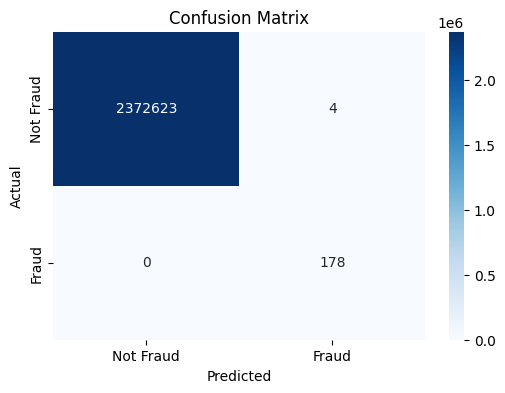

In [90]:
# 22. Example usage of the model pipeline
data_processed,y=prepare_data_for_prediction(raw_data)
data_processed.to_csv('data_processed.csv', index=False)

evaluate_model(data_processed,y, best_model)